In [200]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from torch import nn, optim

In [58]:
class OneHotImages(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path

        # Images
        self.files = os.listdir(os.path.join(file_path, "img"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = torch.load(os.path.join(self.file_path, "img", self.files[idx]))

        with open(
            os.path.join(self.file_path, "labels", self.files[idx][:-3] + ".txt")
        ) as fp:
            label = float(fp.read())

        return img, torch.tensor(label, dtype=torch.float)

In [192]:
train = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train")
test = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/test")

In [263]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.intercept = 75

        self.weight = nn.Parameter(torch.randn(256, 256, 4))
        
        self.softplus = nn.Softplus()
        
        torch.nn.init.uniform_(self.weight, a = 0.00001, b = 0.1)

        self.to('cuda')
    def forward(self, X):
        return self.intercept + (F.relu(self.weight) * X).sum(axis=(1,2,3))


In [264]:
model.intercept

75

In [265]:
model = SimpleModel()

In [287]:
train_loader = DataLoader(train, batch_size=1)
test_loader = DataLoader(test, batch_size=1)

In [267]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [268]:
for epoch in range(10):

    train_loss = 0
    count = 0
    model.train()
    for X, y in train_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        optimizer.zero_grad()
        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)

        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()
        count += X.size(0)
        
    print(f"Train loss: {train_loss / count}")
    model.eval()
    test_loss = 0
    count = 0
    for X, y in test_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)
        
        test_loss += loss.item()
        count += X.size(0)
        
    print(f"Test loss: {test_loss / count}")

Train loss: 11336.09816824237
Test loss: 0.41895885349060435
Train loss: 0.40656568140076527
Test loss: 0.40822768359450823
Train loss: 0.3869451772140519
Test loss: 0.4475870547087296
Train loss: 0.3829371222274083
Test loss: 0.4203734072098821
Train loss: 0.37838774913175705
Test loss: 0.4363511956256369
Train loss: 0.3769873924133755
Test loss: 0.4334883719497586
Train loss: 0.3757050460507335
Test loss: 0.43869888116113887
Train loss: 0.37510252657656207
Test loss: 0.4399602427986098
Train loss: 0.3745296267469935
Test loss: 0.4420418117357337
Train loss: 0.37428480912471046
Test loss: 0.44316968266267953


In [269]:
y_preds = []
y_actual = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to('cuda')
        y_actual.extend(y)

        y_hat = model(X)
        y_preds.extend(y_hat.cpu().numpy())

In [270]:

from sklearn.metrics import r2_score

r2_score(y_actual, y_preds)

-5.770088794783809

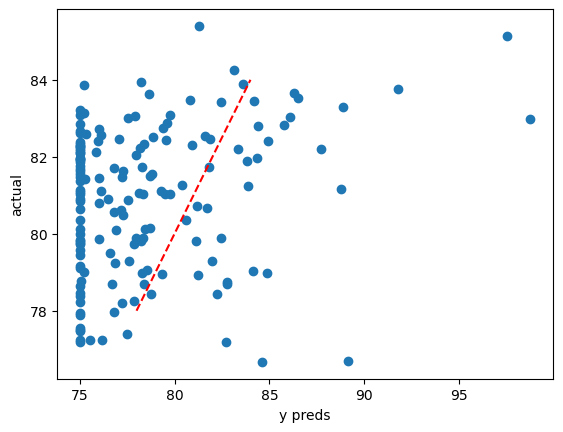

In [271]:
from matplotlib import pyplot as plt
plt.scatter(y_preds, y_actual)
plt.plot(np.linspace(78, 84, 2), np.linspace(78, 84, 2), 'r--')
plt.xlabel("y preds")
plt.ylabel("actual")
plt.show()

In [303]:
X_train_s = []
y_train_s = []
for X, y in train_loader:
    X_train_s.append(X[0].numpy().mean(axis=(0,1)))
    y_train_s.append(y[0].item())
    
    
X_test_s = []
y_test_s = []
for X, y in test_loader:
    X_test_s.append(X[0].numpy().mean(axis=(0,1)))
    y_test_s.append(y[0].item())
    

In [304]:
X_train_s = np.array(X_train_s)
X_test_s = np.array(X_test_s)

In [305]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train_s, y_train_s)

LinearRegression()

In [306]:
preds = lm.predict(X_test_s)

In [307]:
r2_score(y_test_s, preds)

0.25651230021743976

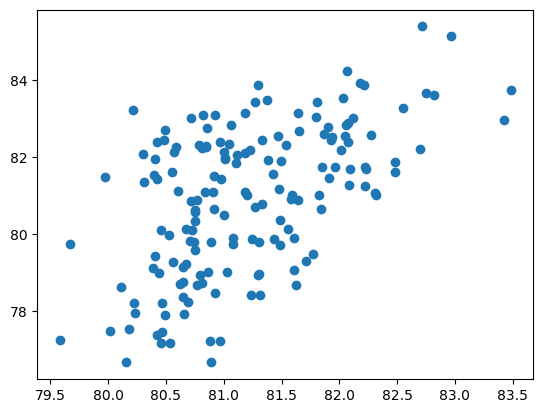

In [309]:
plt.scatter(preds, y_test_s)

In [310]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train_s, y_train_s)

preds = dt.predict(X_test_s)

r2_score(y_test_s, preds)

-0.3615071020071128

In [313]:
lm.coef_

array([-0.20859339, -3.0248333 , -4.3525533 ,  7.58597999])

In [315]:
lm.intercept_

83.54279165744097

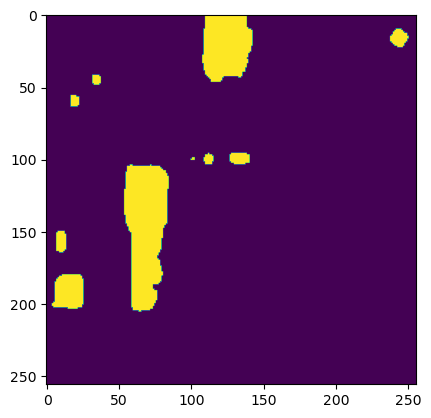

In [185]:
plt.imshow(X[0,:, :, 3].cpu().numpy())

In [176]:
len(y_actual)

941

In [177]:
model.intercept

Parameter containing:
tensor(78.9949, device='cuda:0', requires_grad=True)